In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Real-Time Hand Gesture Recognition App
**Model**: EfficientNetV2B0 (Best balance of speed/accuracy)  
**Dataset**: HG14 (14 gesture classes)  
**Output**: Gesture-controlled actions  

In [1]:
!pip install -q opencv-python matplotlib tensorflow

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-01 21:40:33.765153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746135633.791751     631 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746135633.798666     631 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Dataset
dataset_path = "/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture"
classes = sorted(os.listdir(dataset_path))
print("Gesture Classes:", classes)

Gesture Classes: ['Gesture_0', 'Gesture_1', 'Gesture_10', 'Gesture_11', 'Gesture_12', 'Gesture_13', 'Gesture_2', 'Gesture_3', 'Gesture_4', 'Gesture_5', 'Gesture_6', 'Gesture_7', 'Gesture_8', 'Gesture_9']


In [4]:
# Split into train/val
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Normalize pixel values to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 14000 files belonging to 14 classes.
Using 11200 files for training.


I0000 00:00:1746135725.226688     631 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746135725.227481     631 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 14000 files belonging to 14 classes.
Using 2800 files for validation.


In [5]:
# Build Model
def build_model():
    base_model = EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3),
        pooling='avg'
    )
    base_model.trainable = True  # unFreeze layers
    # Fine-tune from this layer onward
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False  # Freeze early layers
    return tf.keras.Sequential([
        base_model,
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')
    ])

model = build_model()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 1280)                │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           3,598 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,250,846 (23.85 MB)

 Trainable params: 5,487,182 (20.93 MB)

 Non-trainable params: 763,664 (2.91 MB)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9029 - loss: 0.2916 - val_accuracy: 0.8761 - val_loss: 0.3790
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9064 - loss: 0.2830 - val_accuracy: 0.8939 - val_loss: 0.3634
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9089 - loss: 0.2841 - val_accuracy: 0.9011 - val_loss: 0.3334
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9179 - loss: 0.2575 - val_accuracy: 0.8943 - val_loss: 0.3819
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9137 - loss: 0.2629 - val_accuracy: 0.8896 - val_loss: 0.4171
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9228 - loss: 0.2394 - val_accuracy: 0.8918 - val_loss: 0.4137
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9201 - loss: 0.2582 - val_accuracy: 0.8961 - val_loss: 0.3582
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9249 - loss: 0.2409 - 

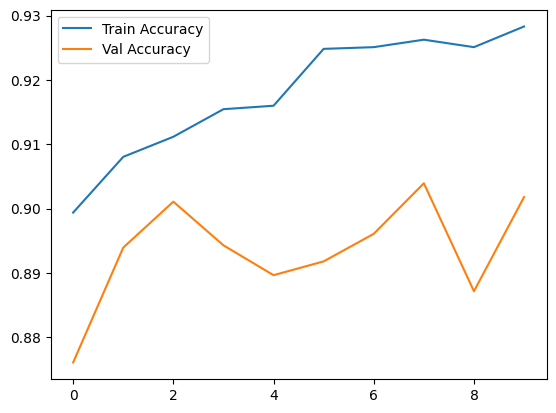

In [23]:
# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

In [24]:
# Test on Sample Images
def predict_gesture(img_path, true_class=None):
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)

    pred = model.predict(img_array)
    predicted_class = classes[np.argmax(pred)]

    plt.imshow(img)
    if true_class:
        plt.title(f"True: {true_class}\nPredicted: {predicted_class}")
    else:
        plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


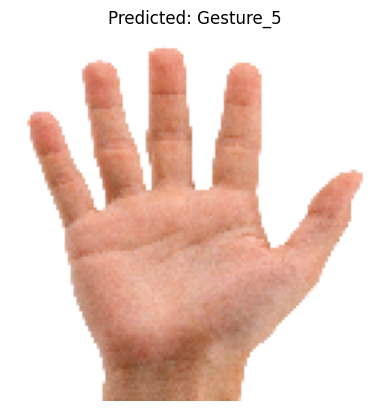

In [25]:
predict_gesture("/kaggle/input/idkkkk/5.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


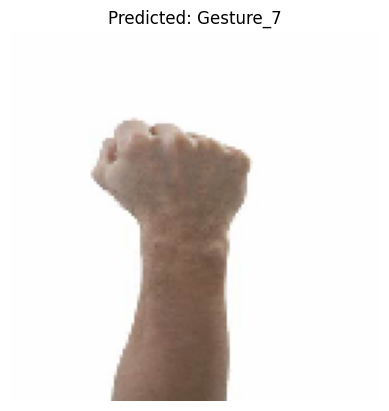

In [26]:
predict_gesture("/kaggle/input/idkkkk/OIP (7).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


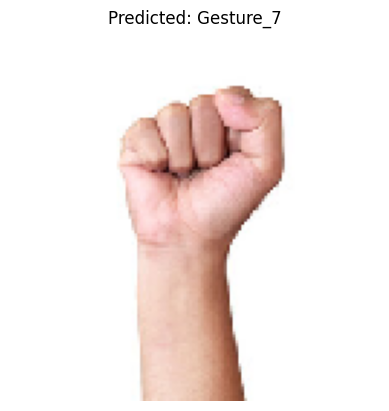

In [27]:
predict_gesture("/kaggle/input/idkkkk/0.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


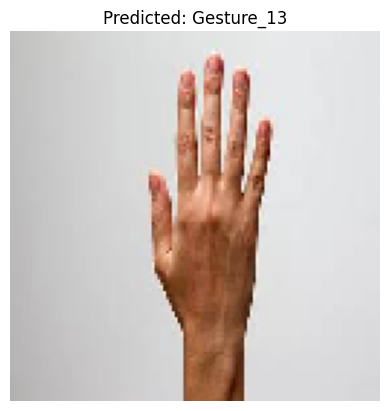

In [28]:
predict_gesture("/kaggle/input/idkkkk/download (1).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


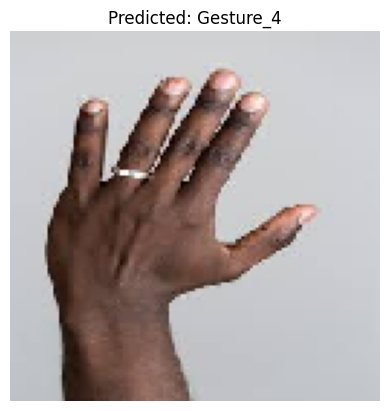

In [29]:
predict_gesture("/kaggle/input/idkkkk/images.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


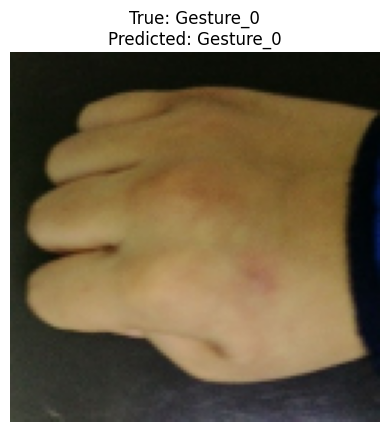

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


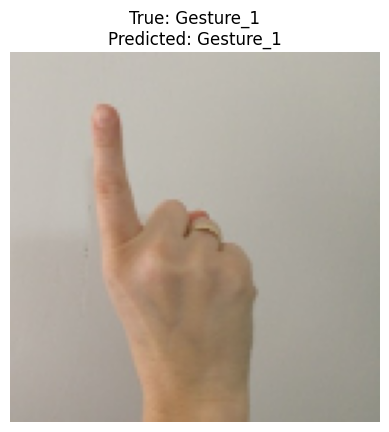

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


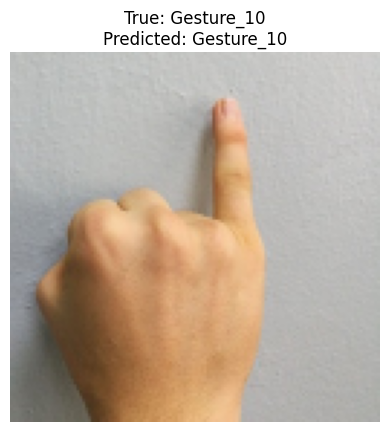

In [30]:

# Test on 3 samples per class
for class_name in classes[:3]:  # Test first 3 classes for demo
    class_dir = os.path.join(dataset_path, class_name)
    sample_img = os.listdir(class_dir)[0]  # Take first image
    predict_gesture(
        os.path.join(class_dir, sample_img),
        true_class=class_name
    )

In [ ]:
# Save Model for Later Use
model.save("static_gesture_model.h5")